# NLP III: Taggers in NLP

## Previously in NLP

In previous notebooks, we explored Context-Free Grammars (CFG). In essence, with CFG, we have a set of tokens (words) to which we assign specific tags. These tags are then organized and classified based on predefined rules. We've identified that this approach has limitations, especially when encountering words that aren't part of our training set—those words simply won't be recognized.

A potential solution to this problem is using taggers. With the EAGLES standard, we can develop a tagging system that leverages techniques such as N-Grams, Hidden Markov Models, and others.

To kick things off, let's import our go-to library for tokenization!

In [1]:
import nltk
from nltk import UnigramTagger, BigramTagger, TrigramTagger #N-Gram
from nltk.tag.hmm import HiddenMarkovModelTagger
from nltk.chunk.regexp import *

# Import your library. Type your code here:
from Libraries import tokenization

# We don't need to import the following library, do you understand why?
# from nltk.tokenize import word_tokenize

In [2]:
phrase = 'El niño tiene unos zapatos'
tokens = tokenization.tokenize(phrase)
print(tokens)

['el', 'niño', 'tiene', 'unos', 'zapatos']


Let us train the taggers! 

I.e., let us create the list of tuples: ('word', 'tag')

Tags can be found here:

https://www.cs.upc.edu/~nlp/tools/parole-sp.html

This page sounds familiar?

I've already written the code, so you don't have to suffer =)

**But please, understad how it works!**

In [3]:
train_corpus  = [
    [('el', 'tdms0'), ('niño', 'ncms000'), ('tiene', 'vmip3s0'), ('unos', 'di3mp00'), ('zapatos', 'ncmp000')],
    [('la', 'tdfs0'), ('abuela', 'ncfs000'), ('cocina', 'vmip3s0'), ('un', 'di3ms00'), ('pastel', 'ncms000')],
    [('el', 'tdms0'), ('abuelo', 'ncms000'), ('compra', 'vmip3s0'), ('un', 'di3ms00'), ('bastón', 'ncms000')]
]

## Tagger training

**¡** 👁️ **! Words with or without 'tildes' are different tags!**

We've previously discussed how to train taggers, remember?

In [4]:
unigram  = UnigramTagger(train_corpus)
bigram   = BigramTagger(train_corpus, backoff=unigram)
trigram  = TrigramTagger(train_corpus, backoff=bigram)
hmm      = HiddenMarkovModelTagger.train(train_corpus)

Training is evidently a quick process given the limited amount of data. However, it is nearly useless given the limited amount of data.

In any case, let's see how it works in all its glory.

In [5]:
test_phrase = 'El niño cocina unos bastones'

print('Tri: ', trigram.tag(tokenization.tokenize(test_phrase)))
print('Hmm: ', hmm.tag(tokenization.tokenize(test_phrase)))

Tri:  [('el', 'tdms0'), ('niño', 'ncms000'), ('cocina', 'vmip3s0'), ('unos', 'di3mp00'), ('bastones', None)]
Hmm:  [('el', 'tdms0'), ('niño', 'ncms000'), ('cocina', 'vmip3s0'), ('unos', 'di3mp00'), ('bastones', 'ncmp000')]


Is the tagg of both correct? Which one performs better? The trigram or the HMM?

And what is the HMM?

And what about this phrase?

In [6]:
frase_test = 'La niña tiene una pelota de baloncesto amarilla'
print('Hmm: ', hmm.tag(tokenization.tokenize(frase_test)))

Hmm:  [('la', 'tdfs0'), ('niña', 'ncfs000'), ('tiene', 'vmip3s0'), ('una', 'di3ms00'), ('pelota', 'ncms000'), ('de', 'vmip3s0'), ('baloncesto', 'di3mp00'), ('amarilla', 'ncmp000')]


**NIIIIIIICE!!!!!**

**HEY! NO, WAIT!!!**

Do not go too fast!!! This algorithm prefers to put something instead of None.

**Let's Break This Down**

Algorithms, especially statistical ones, often exhibit a behavior we might call "pattern mimicry". They don't truly "understand" the nuances of human language. Models like N-grams, HMM, and many others base their decisions on statistical patterns found in the training data, not on genuine comprehension of grammatical or semantic rules. Here's what's happening:

1) **Lack of Real Understanding:** The algorithm doesn’t grasp grammar as we do. It sees sequences, counts occurrences, and predicts based on those counts. It recognizes patterns of position and sequence: which word comes before, which one follows, etc.

2) **Preference Over 'None':** These algorithms are averse to producing 'None' as an output. They’d rather produce a label, even if it's not the most accurate one, based on the patterns they've observed in the training data.

3) **Mistakes in Labeling:** As you've rightly noticed (or not?), errors crop up: ('una', 'di3ms00') should indeed be ('una', 'di3fs00') to represent the feminine form.
Similarly, ('pelota', 'ncms000') should be ('pelota', 'ncfs000') since "pelota" is feminine.

And if you look carefully enough, in the rest, ('de', 'vmip3s0'), ('baloncesto', 'di3mp00'), ('amarilla', 'ncmp000'), is just repeaging the structure that it learns when training: vmi, di, nc. It does not hit any anyone :(

4) **Repetition of Training Data:** If your model seems to be just repeating structures it learned during training without applying them correctly to new data, it's a sign that it may be overfitting to the training data and not generalizing well to new examples.

The algorithm is just repeating the structure of the training set 🧐   


In essence, while these models are powerful and can be quite accurate with enough diverse data, they have limitations. They're excellent pattern recognizers but not linguistic experts. Always review the outputs to understand both the strengths and limitations of these tools.

## Training a Tagger

Alright, let's dive a little deeper into the world of taggers. We've seen how they can sometimes produce quirky results, right? Now, let's see if we can train one to behave a bit more to our liking.

To train a tagger, we essentially need to "teach" it about the relationship between words and their corresponding grammatical tags. Think of it like showing a child pictures of different animals and saying, "This is a dog," "This is a cat," and so on. Over time, the child (or in our case, the tagger) learns to recognize and label these animals (or words) on their own.

To do this, we utilize a tagged corpus. A corpus is a large and structured set of texts, and a tagged corpus is one where each word in the text is paired with its grammatical tag.

**Why is it Important?:** By examining a tagged corpus, our tagger can start to identify patterns, like "Hey, the word 'runs' is often tagged as a verb." Over time, and with enough examples, it can start making educated guesses about words it hasn't seen before.

Let's now peek into the English tagged corpus to understand its contents and structure:

In [7]:
from nltk.corpus import cess_esp
print(cess_esp.sents()[0])

['El', 'grupo', 'estatal', 'Electricité_de_France', '-Fpa-', 'EDF', '-Fpt-', 'anunció', 'hoy', ',', 'jueves', ',', 'la', 'compra', 'del', '51_por_ciento', 'de', 'la', 'empresa', 'mexicana', 'Electricidad_Águila_de_Altamira', '-Fpa-', 'EAA', '-Fpt-', ',', 'creada', 'por', 'el', 'japonés', 'Mitsubishi_Corporation', 'para', 'poner_en_marcha', 'una', 'central', 'de', 'gas', 'de', '495', 'megavatios', '.']


In [8]:
cess_esp.tagged_sents()

[[('El', 'da0ms0'), ('grupo', 'ncms000'), ('estatal', 'aq0cs0'), ('Electricité_de_France', 'np00000'), ('-Fpa-', 'Fpa'), ('EDF', 'np00000'), ('-Fpt-', 'Fpt'), ('anunció', 'vmis3s0'), ('hoy', 'rg'), (',', 'Fc'), ('jueves', 'W'), (',', 'Fc'), ('la', 'da0fs0'), ('compra', 'ncfs000'), ('del', 'spcms'), ('51_por_ciento', 'Zp'), ('de', 'sps00'), ('la', 'da0fs0'), ('empresa', 'ncfs000'), ('mexicana', 'aq0fs0'), ('Electricidad_Águila_de_Altamira', 'np00000'), ('-Fpa-', 'Fpa'), ('EAA', 'np00000'), ('-Fpt-', 'Fpt'), (',', 'Fc'), ('creada', 'aq0fsp'), ('por', 'sps00'), ('el', 'da0ms0'), ('japonés', 'aq0ms0'), ('Mitsubishi_Corporation', 'np00000'), ('para', 'sps00'), ('poner_en_marcha', 'vmn0000'), ('una', 'di0fs0'), ('central', 'ncfs000'), ('de', 'sps00'), ('gas', 'ncms000'), ('de', 'sps00'), ('495', 'Z'), ('megavatios', 'ncmp000'), ('.', 'Fp')], [('Una', 'di0fs0'), ('portavoz', 'nccs000'), ('de', 'sps00'), ('EDF', 'np00000'), ('explicó', 'vmis3s0'), ('a', 'sps00'), ('EFE', 'np00000'), ('que', 'c

As we can see, with the command `cess_esp.sents()` we get a set of tokenised phrases of different themes.

And with the command `cess_esp.tagged_sents()` we get the same set of tagged sentences.

Can you please characterize the tagged corpus structure?

- Count the words, sentences, etc. 
- Come on, little data scientist! Explore data!

In [9]:
# Type your code here:

# Count the total number of words in the Spanish CESS corpus
total_words = sum(len(sentence) for sentence in cess_esp.sents())

# Count the total number of sentences in the corpus
total_sentences = len(cess_esp.sents())

# Print the results
print(f"Total number of words in the corpus: {total_words}")
print(f"Total number of sentences in the corpus: {total_sentences}")

Total number of words in the corpus: 192686
Total number of sentences in the corpus: 6030


**Easy excercise:** Merge your original corpus (`train_corpus`), with the tagged corpus: 

In [10]:
# Type your code here:

for sentence in cess_esp.tagged_sents():
    train_corpus.append(sentence)

In [11]:
print(train_corpus)

[[('el', 'tdms0'), ('niño', 'ncms000'), ('tiene', 'vmip3s0'), ('unos', 'di3mp00'), ('zapatos', 'ncmp000')], [('la', 'tdfs0'), ('abuela', 'ncfs000'), ('cocina', 'vmip3s0'), ('un', 'di3ms00'), ('pastel', 'ncms000')], [('el', 'tdms0'), ('abuelo', 'ncms000'), ('compra', 'vmip3s0'), ('un', 'di3ms00'), ('bastón', 'ncms000')], [('El', 'da0ms0'), ('grupo', 'ncms000'), ('estatal', 'aq0cs0'), ('Electricité_de_France', 'np00000'), ('-Fpa-', 'Fpa'), ('EDF', 'np00000'), ('-Fpt-', 'Fpt'), ('anunció', 'vmis3s0'), ('hoy', 'rg'), (',', 'Fc'), ('jueves', 'W'), (',', 'Fc'), ('la', 'da0fs0'), ('compra', 'ncfs000'), ('del', 'spcms'), ('51_por_ciento', 'Zp'), ('de', 'sps00'), ('la', 'da0fs0'), ('empresa', 'ncfs000'), ('mexicana', 'aq0fs0'), ('Electricidad_Águila_de_Altamira', 'np00000'), ('-Fpa-', 'Fpa'), ('EAA', 'np00000'), ('-Fpt-', 'Fpt'), (',', 'Fc'), ('creada', 'aq0fsp'), ('por', 'sps00'), ('el', 'da0ms0'), ('japonés', 'aq0ms0'), ('Mitsubishi_Corporation', 'np00000'), ('para', 'sps00'), ('poner_en_marc

And train again with this bigger corpus.

In [12]:
# Type your code here:

unigram  = UnigramTagger(train_corpus)
bigram   = BigramTagger(train_corpus, backoff=unigram)
trigram  = TrigramTagger(train_corpus, backoff=bigram)
hmm      = HiddenMarkovModelTagger.train(train_corpus)

In [13]:
test_phrase = 'La niña tiene una pelota de baloncesto amarilla'

print('Tri: ', trigram.tag(tokenization.tokenize(test_phrase)))
print('Hmm: ', hmm.tag(tokenization.tokenize(test_phrase)))

Tri:  [('la', 'tdfs0'), ('niña', 'ncfs000'), ('tiene', 'vmip3s0'), ('una', 'di0fs0'), ('pelota', 'ncfs000'), ('de', 'sps00'), ('baloncesto', 'ncms000'), ('amarilla', 'aq0fs0')]
Hmm:  [('la', 'da0fs0'), ('niña', 'ncfs000'), ('tiene', 'vmip3s0'), ('una', 'di0fs0'), ('pelota', 'ncfs000'), ('de', 'sps00'), ('baloncesto', 'ncms000'), ('amarilla', 'aq0ms0')]


You might observe a discrepancy in the tags assigned to 'la'. The Trigram tagger assigns 'tdfs0', while the HMM tagger assigns 'da0fs0'. This discrepancy arises because we trained the Trigram with the 'tdfs0' tag.

## Crafting Grammar Rules

The term "grammar" in linguistics refers to the set of structural rules governing the composition of clauses, phrases, and words in any given natural language. Grammar is the foundation of every language. These rules determine how words and phrases can be combined to form valid sentences in a language.

Grammar encompasses a range of concepts:

1) **Syntax:** Deals with the arrangement of words and phrases to create well-formed sentences.
2) **Morphology:** Concerns the structure of words, including affixes (prefixes, suffixes), stems, root words, and other morphemes.
3) **Phonology:** Studies the way sounds function within a particular language or languages.
4) **Semantics:** Examines the meaning of words, phrases, and sentences.
5) **Pragmatics:** Analyzes the ways in which context influences the interpretation of meaning.
Every language has its own distinct grammar, and while there are universal principles, the specifics can vary widely between languages.


In our previous notebook, we focused on establishing rules based on context-free grammar, where we explicitly specified relationships between tokens and their respective tags. While this method provided us with a basic structure to analyze and generate specific phrases, it had limitations, especially when faced with unfamiliar words or varied sentence structures.

This time, we'll approach grammar rule creation in a more dynamic and robust manner, accommodating a wider range of sentence structures and lexical variations. 

Let's formulate these rules. We'll employ a methodology akin to what we explored in the previous notebook, albeit with a distinct approach:

- Each line represents a distinct rule.
- Establish a rule for 'Who', which denotes the subject.
- Define a rule for the action or possession associated with the subject.

This method is more efficient because you don't have to tag each individual word as we did in the previous notebook. Instead, you only need to provide rules for the tags  🥳

In [14]:
grammar = r'''
Quien: {<nc.*>}
Que: {}
'''

# Then let us create the parser:
parser = nltk.RegexpParser(grammar)

The rule 'Who' would be, for instance, for the child. The rule is `<nc.*>`, representing any sequence that starts with 'nc'; it acts like a wildcard. For instance, it is equivalent to `<ncfs000 | ncms000>`.

In [15]:
def my_parser(_tokens):
    return parser.parse(_tokens)

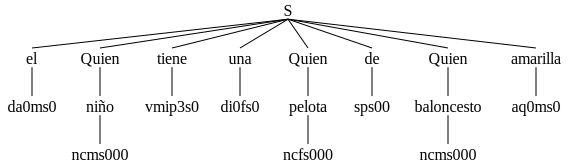

In [16]:
test_phrase = 'El niño tiene una pelota de baloncesto amarilla'
my_parser(hmm.tag(tokenization.tokenize(test_phrase)))

This rule isn't entirely accurate. When we query 'Who', the responses are "niño", "pelota", and "baloncesto". This is because the algorithm categorizes all entries matching 'nc.\*' under 'Who'. However, the true response for 'Who' should be "niño" since it's the subject, being preceded by a '<da0.*>'.

**Incorporate this rule!**

Where should you place it: before or after the brace ('{')?

In [17]:
# Complete with your code:

grammar = r'''
Quien: <da0.*> {<nc.*>}
Que: {}
'''

parser = nltk.RegexpParser(grammar)

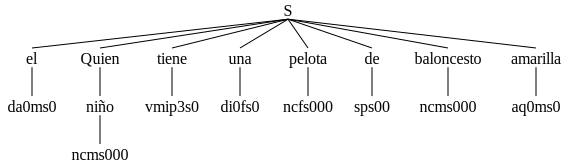

In [18]:
test_phrase = 'El niño tiene una pelota de baloncesto amarilla'
my_parser(hmm.tag(tokenization.tokenize(test_phrase)))

**We've now successfully identified the subject of the sentence!**

Is everything ok?

Are you certain?

But what about 'amarilla'? Shouldn't it be labeled as 'aq0fs0'?

Mislabeling is a common problem when training algorithms. To address such issues, you'd typically need to retrain your model with the corrected data.

**Exercise:** You know the task ahead... Ensure your algorithm doesn't mislabel 'amarilla'.

**Warning:**  Always remember that when you're training or retraining, you should focus on entire sentences, not individual words or tokens. Retraining only with 'amarilla' might jeopardize your entire model! 😮

**Hint:** You don't need to retrain the tagger from scratch! With Hidden Markov Models, you can specifically retrain on mislabeled instances using:

`hmm = hmm.train(fix_tag)`

In [19]:
# Type your code here:

hmm.tag(tokenization.tokenize(test_phrase))

[('el', 'da0ms0'),
 ('niño', 'ncms000'),
 ('tiene', 'vmip3s0'),
 ('una', 'di0fs0'),
 ('pelota', 'ncfs000'),
 ('de', 'sps00'),
 ('baloncesto', 'ncms000'),
 ('amarilla', 'aq0ms0')]

In [20]:
# Let us fix the taggs:

fix = [
    [('el', 'da0ms0'),
 ('niño', 'ncms000'),
 ('tiene', 'vmip3s0'),
 ('una', 'di0fs0'),
 ('pelota', 'ncfs000'),
 ('de', 'sps00'),
 ('baloncesto', 'ncms000'),
 ('amarilla', 'aq0fs0')]
]

hmm = hmm.train(fix)

If your code is correct, running the following cell should yield the correct tags  :)

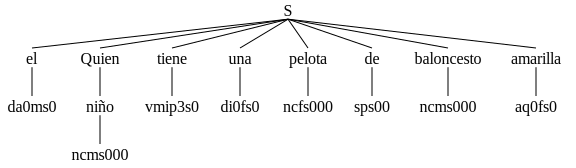

In [21]:
test_phrase = 'El niño tiene una pelota de baloncesto amarilla'
my_parser(hmm.tag(tokenization.tokenize(test_phrase)))

Now let us give rules to the predicative.

In [22]:
grammar = r'''
Suj: {<da0.*> <ncfs000 | ncms000>}
Pred: <Suj> {<.*>*}
'''
parser = nltk.RegexpParser(grammar)

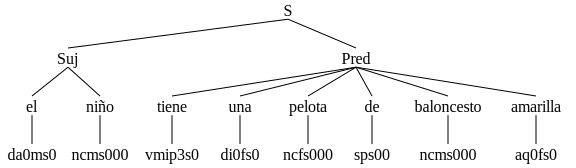

In [23]:
test_phrase = 'El niño tiene una pelota de baloncesto amarilla'
my_parser(hmm.tag(tokenization.tokenize(test_phrase)))

As previously mentioned multiple times, you can introduce various types of subjects on separate lines in `grammar` (the subject of a sentence can take various forms). However, always ensure they are ordered from the most restrictive to the least restrictive.

Let's proceed with the rules inside the predicate, such as the direct object complement:

In [24]:
grammar = r'''
Suj: {<da0.*> <ncfs000 | ncms000>}
DOC: <vmi.*> {<.*>*}
Pred: <Suj> {<vmi.*> <DOC>}
'''
parser = nltk.RegexpParser(grammar)

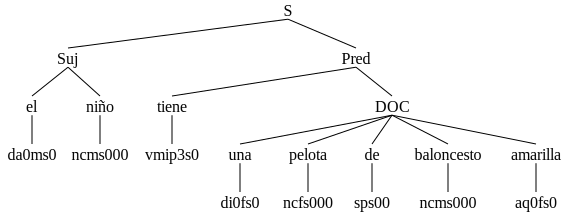

In [25]:
test_phrase = 'El niño tiene una pelota de baloncesto amarilla'
my_parser(hmm.tag(tokenization.tokenize(test_phrase)))

We need to redefine our grammer. Check what happens if tou analyze the phrase "el abuelo come":

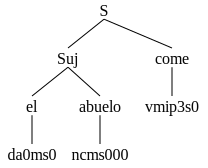

In [26]:
# Type your code here:
test_phrase = 'El abuelo come'
my_parser(hmm.tag(tokenization.tokenize(test_phrase)))

I will redefine the grammer for you.

You are welcome ;)

In [27]:
grammar = r'''
Suj: {<da0.*> <ncfs000 | ncms000>}
PP: <nc.*> {<sp.*> <nc.*>}
DO: <vmi.*> {<di.*> <nc.*> <PP> <aq.*>}
DO: <vmi.*> {<di.*> <nc.*>}
Pred: <Suj> {<vmi.*> <.*>*}
'''
parser = nltk.RegexpParser(grammar)

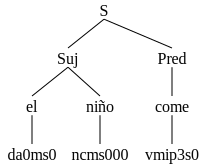

In [28]:
test_phrase = 'El niño come'
my_parser(hmm.tag(tokenization.tokenize(test_phrase)))

In this manner, in 'El niño come', the predicate is recognized.

I've also added the analysis for the Prepositional Phrase (PP) that modifies 'pelota'.

You are welcome again!

Try how it works!!!

In [48]:
# Type your code here:
🤷‍♂️

## Things You Learn Are Not Isolated Islands!

Remember, the skills and techniques you learn are not isolated; they're part of a broader toolkit that you can apply in versatile ways. Recall how you've learned to divide datasets into training and testing sets? We'll employ this same foundational concept here in the realm of NLP. 

Specifically, we'll divide our tagged tokens into two sets. The first set, intended for training, will contain 90% of the tokens. The second set, allocated for testing, will contain the remaining 10%. As we proceed, we'll compare the performance of various taggers, including Unigram, Bigram, Trigram, and the Hidden Markov Model.

### Tagger training

Before we can effectively train our taggers, we need to understand the dataset we're working with. We'll begin by exploring a well-structured tagging corpus that consists of tokenized phrases from various themes. This foundational understanding will equip us to train our tagger models more effectively.

In [29]:
cess_esp.sents()

[['El', 'grupo', 'estatal', 'Electricité_de_France', '-Fpa-', 'EDF', '-Fpt-', 'anunció', 'hoy', ',', 'jueves', ',', 'la', 'compra', 'del', '51_por_ciento', 'de', 'la', 'empresa', 'mexicana', 'Electricidad_Águila_de_Altamira', '-Fpa-', 'EAA', '-Fpt-', ',', 'creada', 'por', 'el', 'japonés', 'Mitsubishi_Corporation', 'para', 'poner_en_marcha', 'una', 'central', 'de', 'gas', 'de', '495', 'megavatios', '.'], ['Una', 'portavoz', 'de', 'EDF', 'explicó', 'a', 'EFE', 'que', 'el', 'proyecto', 'para', 'la', 'construcción', 'de', 'Altamira_2', ',', 'al', 'norte', 'de', 'Tampico', ',', 'prevé', 'la', 'utilización', 'de', 'gas', 'natural', 'como', 'combustible', 'principal', 'en', 'una', 'central', 'de', 'ciclo', 'combinado', 'que', 'debe', 'empezar', 'a', 'funcionar', 'en', 'mayo_del_2002', '.'], ...]

In [30]:
cess_esp.tagged_sents()

[[('El', 'da0ms0'), ('grupo', 'ncms000'), ('estatal', 'aq0cs0'), ('Electricité_de_France', 'np00000'), ('-Fpa-', 'Fpa'), ('EDF', 'np00000'), ('-Fpt-', 'Fpt'), ('anunció', 'vmis3s0'), ('hoy', 'rg'), (',', 'Fc'), ('jueves', 'W'), (',', 'Fc'), ('la', 'da0fs0'), ('compra', 'ncfs000'), ('del', 'spcms'), ('51_por_ciento', 'Zp'), ('de', 'sps00'), ('la', 'da0fs0'), ('empresa', 'ncfs000'), ('mexicana', 'aq0fs0'), ('Electricidad_Águila_de_Altamira', 'np00000'), ('-Fpa-', 'Fpa'), ('EAA', 'np00000'), ('-Fpt-', 'Fpt'), (',', 'Fc'), ('creada', 'aq0fsp'), ('por', 'sps00'), ('el', 'da0ms0'), ('japonés', 'aq0ms0'), ('Mitsubishi_Corporation', 'np00000'), ('para', 'sps00'), ('poner_en_marcha', 'vmn0000'), ('una', 'di0fs0'), ('central', 'ncfs000'), ('de', 'sps00'), ('gas', 'ncms000'), ('de', 'sps00'), ('495', 'Z'), ('megavatios', 'ncmp000'), ('.', 'Fp')], [('Una', 'di0fs0'), ('portavoz', 'nccs000'), ('de', 'sps00'), ('EDF', 'np00000'), ('explicó', 'vmis3s0'), ('a', 'sps00'), ('EFE', 'np00000'), ('que', 'c

As stated before, we will now create two sets of tagged tokens. The first set will contain 80% of the tokens for training, while the second set will comprise the remaining 20% for testing.

In [45]:
from sklearn.model_selection import train_test_split

#Generamos los conjuntos de Train y Test
data_train, data_test = train_test_split(cess_esp.tagged_sents(), test_size=0.20, random_state=1)

print('Train tokens:',len(data_train),
      '\nTokens test: ',len(data_test))

Train tokens: 4824 
Tokens test:  1206


Having the sets already created, we move on to train the taggers.

To train the N-grams we must execute the tagger with the corpus, for example `UnigramTagger(data_train)`. We will see that the N-grams can have as backoff another (N-1)-grams.

In the case of HiddenMarkovModelTagger we must execute the function `.train()`.

In [46]:
unigram  = UnigramTagger(data_train)
bigram   = BigramTagger(data_train, backoff=unigram)
trigram  = TrigramTagger(data_train, backoff=bigram)
hmm      = HiddenMarkovModelTagger.train(data_train)

Once the taggers are trained, we'll proceed to evaluate their performance using the test set. To accomplish this, we'll utilize the `.accuracy()` function for each of the taggers under test. Let's examine how each performs.

When running the testing script, be mindful of the execution time for each tagger. You'll find that while the N-gram taggers are relatively quick at extracting information, the HMM takes longer to process the data. This is one of the reasons why I opted for an 80-20% training-testing split; assessing the accuracy for the HMM tagger was quite time-consuming.

In [47]:
print ('Acierto con unigramas: %.2f %%' % (unigram.accuracy(data_test)*100))
print ('Acierto con bigramas:  %.2f %%' % (bigram.accuracy(data_test)*100))
print ('Acierto con trigramas: %.2f %%' % (trigram.accuracy(data_test)*100))
print ('Acierto con HMMs:      %.2f %%' % (hmm.accuracy(data_test)*100))

Acierto con unigramas: 86.65 %
Acierto con bigramas:  88.16 %
Acierto con trigramas: 88.17 %
Acierto con HMMs:      89.04 %


To wrap up this notebook, retrain all the algorithms using the test set and then evaluate their accuracies using the same test set.

Upon re-evaluating the taggers on the test set, you'll notice that their performance metrics inch closer to 100% accuracy. This improvement is particularly notable in the N-gram taggers as they operate on more straightforward, 'logical' rules. Therefore, even with small volumes of data (like our test set), they tend to perform remarkably well.

In contrast, while the Hidden Markov Model (HMM) may show less dramatic improvement when re-evaluated on the test set, it tends to offer superior performance on unseen data—tokens that were not part of the training set. This characteristic makes the HMM more robust and versatile in real-world applications where the input data can be highly variable.

In [38]:
# Type your code here:
unigram  = UnigramTagger(data_test)
bigram   = BigramTagger(data_test, backoff=unigram)
trigram  = TrigramTagger(data_test, backoff=bigram)
hmm      = HiddenMarkovModelTagger.train(data_test)

print ('Acierto con unigramas: %.2f %%' % (unigram.accuracy(data_test)*100))
print ('Acierto con bigramas:  %.2f %%' % (bigram.accuracy(data_test)*100))
print ('Acierto con trigramas: %.2f %%' % (trigram.accuracy(data_test)*100))
print ('Acierto con HMMs:      %.2f %%' % (hmm.accuracy(data_test)*100))

Acierto con unigramas: 96.67 %
Acierto con bigramas:  98.86 %
Acierto con trigramas: 99.56 %
Acierto con HMMs:      93.62 %
